# Image Classification with CNN using Keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Task 1: Import Libraries

In [6]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('./drive/My Drive/models'):
    os.mkdir('./drive/My Drive/models')
    
print('TensorFlow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

TensorFlow version: 2.2.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU? False


# Task 2: Preprocess Data

In [7]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 2s 0us/step
(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


# Task 3: Visualize Examples

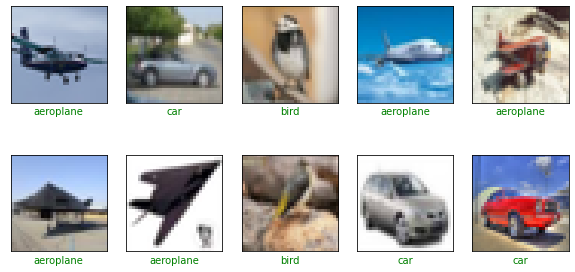

In [9]:
class_names = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indicies = np.random.choice(range(x.shape[0]), 10, replace = False)
    
    x = x[indicies]
    y = y[indicies]
    p = p[indicies] # p - for predictions
    
    plt.figure(figsize = (10, 5))
    for i in range(10):
        plt.subplot(2, 5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red' ## if y is equal to prediction
        plt.xlabel(class_names[np.argmax(p[i])], color = col)
        
    plt.show()
    
show_random_examples(x_train, y_train, y_train)

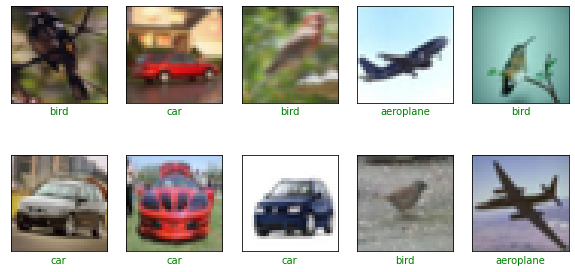

In [10]:
show_random_examples(x_test, y_test, y_test)

# Task 4: Create Model

In [11]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    
    def add_conv_block(model, num_filters):
        # What is batch normalization?
        
        model.add(Conv2D(num_filters, 3, activation = 'relu', padding = 'same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation = 'relu', padding = 'same'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape = (32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model

In [12]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 64)        2

# Task 5: Train the Model

In [13]:
h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs = 10, batch_size = 128,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint(
            './drive/My Drive/models/model_{val_accuracy:.3f}.h5',
            save_best_only=True,
            save_weights_only=False,
            monitor='val_accuracy'
        )
    ]
)

Epoch 1/10
118/118 [==============================] - 114s 963ms/step - loss: 0.8954 - accuracy: 0.6869 - val_loss: 2.0325 - val_accuracy: 0.4220
Epoch 2/10
118/118 [==============================] - 114s 967ms/step - loss: 0.5667 - accuracy: 0.7858 - val_loss: 2.2734 - val_accuracy: 0.5050
Epoch 3/10
118/118 [==============================] - 114s 964ms/step - loss: 0.4633 - accuracy: 0.8187 - val_loss: 2.3891 - val_accuracy: 0.5323
Epoch 4/10
118/118 [==============================] - 114s 964ms/step - loss: 0.3927 - accuracy: 0.8487 - val_loss: 0.9998 - val_accuracy: 0.6110
Epoch 5/10
118/118 [==============================] - 113s 962ms/step - loss: 0.3642 - accuracy: 0.8596 - val_loss: 0.5825 - val_accuracy: 0.7760
Epoch 6/10
118/118 [==============================] - 114s 964ms/step - loss: 0.3202 - accuracy: 0.8767 - val_loss: 0.3563 - val_accuracy: 0.8630
Epoch 7/10
118/118 [==============================] - 113s 955ms/step - loss: 0.3043 - accuracy: 0.8805 - val_loss: 0.3824 -

# Task 6: Final Predictions

In [15]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

accs

[0.6868666410446167,
 0.7857999801635742,
 0.8187333345413208,
 0.8486666679382324,
 0.8596000075340271,
 0.8767333626747131,
 0.880466639995575,
 0.8907333612442017,
 0.8913999795913696,
 0.9017333388328552]

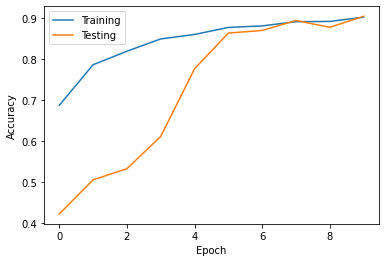

In [19]:
plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# THIS IS TO LOAD MODEL
# model = tf.keras.load_model('./drive/My Drive/models/model_{INSERT MODEL NUMBER}.h5')

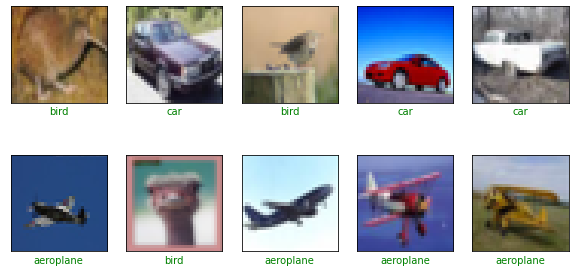

In [17]:
preds = model.predict(x_test/255.)
show_random_examples(x_test, y_test, preds)